In [2]:
from stereo_calibration.rectify import rectify_imgs, make_disparity_map, get_closest_distance, make_colored_distance_map
from image_rec.img_rec import ImgRec
from image_rec.stereoImgRec import create_detection_image, calculate_object_distances
import cv2
from random import random
from matplotlib import pyplot as plt
import numpy as np

### File Distance Map Creation

In [3]:
INPUT_DIR = 'data/stereo_images/TEST'
CALIBRATION_DIR = 'data/stereo_images/scenes/calibration_results'
BASELINE = 0.06
DISTANCE_FACTOR = BASELINE * 5/8 # (25 / 39)

Processing data/stereo_images/TEST/raw/7.png


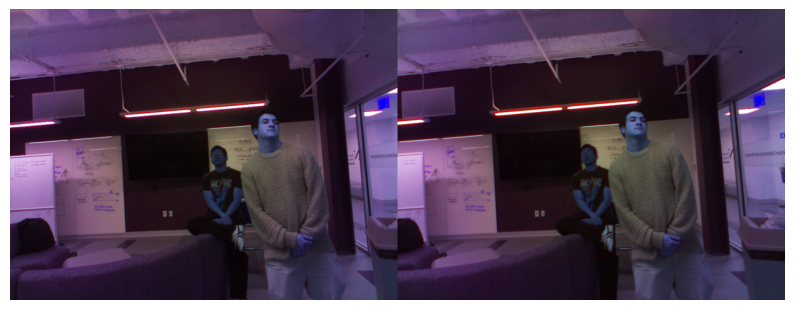

In [4]:
file_num = int(random() * 10) + 1
selected_file = f'{INPUT_DIR}/raw/{file_num}.png'
print(f'Processing {selected_file}')
image = cv2.imread(selected_file)

plt.imshow(image)
plt.axis('off')  # Hide axes
plt.gcf().set_size_inches(10, 10)  # Set the figure size to make the image larger
plt.show()

In [5]:
left = cv2.imread(f'{INPUT_DIR}/left/{file_num}.png')
right = cv2.imread(f'{INPUT_DIR}/right/{file_num}.png')

In [6]:
if left is not None and right is not None:
	left_rectified, right_rectified, Q, focal_length = rectify_imgs(left, right, CALIBRATION_DIR)
else:
	print("Error: One or both of the images are not loaded correctly.")

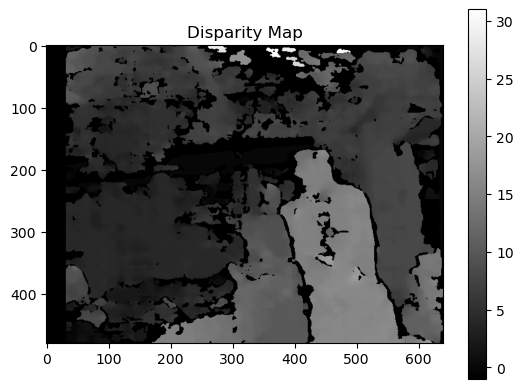

In [7]:
min_disp = 0
num_disp = 16 * 2
block_size = 10
disparity_map = make_disparity_map(left_rectified, right_rectified, min_disp, num_disp, block_size)

# Display disparity map
plt.imshow(disparity_map, 'gray')
plt.title("Disparity Map")
plt.colorbar()
plt.show()


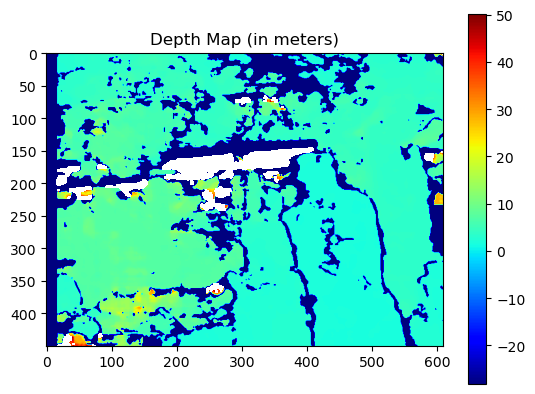

In [8]:
# Step 4: Convert Disparity Map to Depth Map
depth_map = cv2.reprojectImageTo3D(disparity_map, Q)

# Ignore corners and edges of the image
BORDER = 15

# Ensure valid cropping dimensions
height, width = depth_map.shape[:2]
if height > 2 * BORDER and width > 2 * BORDER:
    depth_map = depth_map[BORDER:height - BORDER, BORDER:width - BORDER]
else:
    print("Warning: Border cropping exceeds depth map dimensions, skipping cropping.")

# Extract the Z-values (depth) from the depth map and apply distance factor
distances = depth_map[:, :, 2] * DISTANCE_FACTOR

# Display the Depth Map
fig, ax = plt.subplots()
depth_display = ax.imshow(distances, 'jet')  # Z values represent the depth
plt.colorbar(depth_display)
plt.title("Depth Map (in meters)")
plt.show()


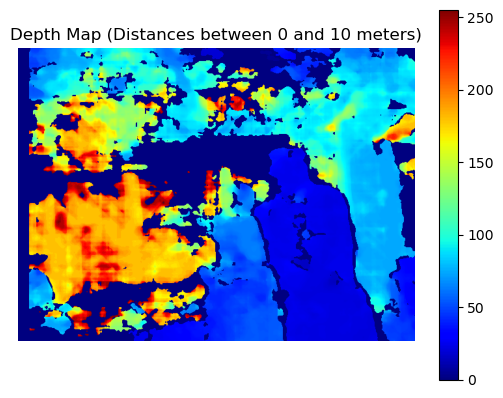

In [9]:
# Define threshold range
MIN_THRESH = 0
MAX_THRESH = 10

# Create a colored depth map within the threshold range
depth_map_colored = make_colored_distance_map(distances, MIN_THRESH, MAX_THRESH)

fig, ax = plt.subplots()
depth_display = ax.imshow(depth_map_colored, 'jet')
plt.colorbar(depth_display)
plt.title(f"Depth Map (Distances between {MIN_THRESH} and {MAX_THRESH} meters)")
plt.axis('off')
plt.show()

### Closest Object Distance


In [10]:
closest_distance, closest_coordinates = get_closest_distance(distances)
if closest_distance is not None and closest_coordinates is not None:
    print(f'Closest distance: {closest_distance:.2f} meters at coordinates {closest_coordinates}')
else:
    print('No valid distances found.')

Closest distance: 1.61 meters at coordinates (np.int64(329), np.int64(427))


Closest distance: 1.61 meters at coordinates (np.int64(329), np.int64(427))


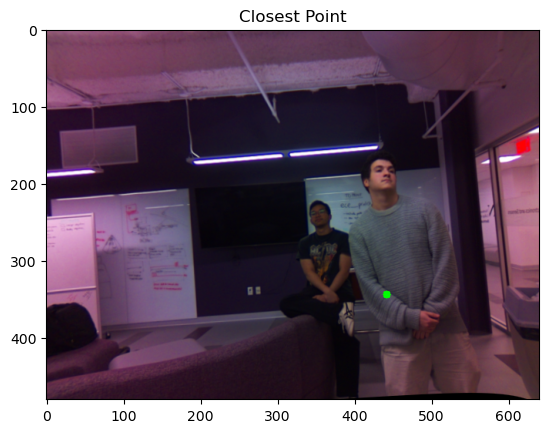

In [11]:

if closest_distance is not None and closest_coordinates is not None:
    print(f'Closest distance: {closest_distance:.2f} meters at coordinates {closest_coordinates}')
    
    # Adjust coordinates for display purposes, since they are affected by cropping
    adjusted_coordinates = (closest_coordinates[0] + BORDER, closest_coordinates[1] + BORDER)

    # Draw the closest point on the original left rectified image
    closest_image = left_rectified.copy()
    cv2.circle(closest_image, adjusted_coordinates[::-1], 5, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(closest_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display with matplotlib
    plt.title("Closest Point")
    plt.show()


### Getting the distances of detected objects

In [12]:
# Image Recognition
img_rec = ImgRec()

In [13]:
# Detections on left rectified image
detected_objects = img_rec.predict_frame(left_rectified)
print('OBJECTS')
print(detected_objects)


0: 480x640 2 persons, 1 couch, 83.1ms
Speed: 2.5ms preprocess, 83.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
OBJECTS
[('person', tensor([[392.8584, 156.3995, 566.5758, 475.8596]]), 0.8791942596435547), ('person', tensor([[302.1501, 220.8514, 408.1241, 479.3596]]), 0.8212897777557373)]


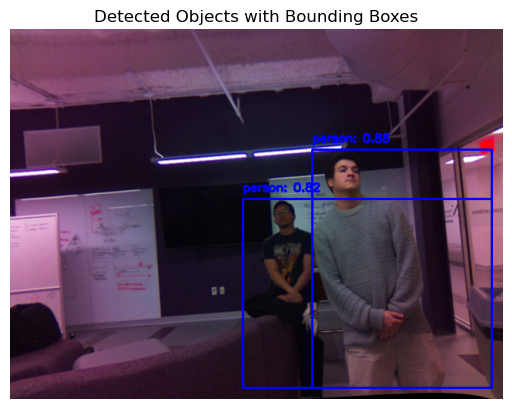

In [14]:
output_image = create_detection_image(left_rectified.copy(), detected_objects, BORDER)

# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display with matplotlib
plt.title("Detected Objects with Bounding Boxes")
plt.axis('off')
plt.show()


In [15]:
object_distances = calculate_object_distances(distances, detected_objects, BORDER)

In [16]:
print('OBJECT DISTANCES')
print(object_distances)

OBJECT DISTANCES
[('person', np.float32(1.7870418)), ('person', np.float32(1.8013381))]
